<div style="text-align: left">
[<img src="./graph/LogoParisSaclay.png" width="850px">](http://www.datascience-paris-saclay.fr)
</div>

#  <a style="color:#920037"> DataCamp Project - Trash Classification </a>

### Authors : Wassim ABIDA - Manon CESAIRE - Alann CHERAL - Jasseur HADDED - Clément HARDY

#### M2 Data Science - Université Paris Saclay  
 
**Professors :** Alexandre GRAMFORT & Balazs KEGL

1. [Business Case](#BusinessCase)
2. [Installation of Librairies](#Imports)
3. [Exploratory Data Analysis](#DataExploration)
4. [Baseline Model](#Baselinemodel)
5. [Submission on RAMP](#SubmissionRAMP)

# <a style="color:#920037"> 1. BUSINESS CASE </a>
## <a style="color:#920037"> 1.1 Introduction </a>

Do you remember the popular sci-fi movie, WALL-E, where robot trash compactors where deployed on Earth to clean the planet after decades of mass consumerism facilitated by a megacorporation ? Even if it seems like an apocalyptic scenario, the movie brought to our notice the harsh environmental reality of today. With the production of almost 1.3 billion tons of waste every day, our interest is to find effective ways to manage our garbages otherwise we could end up in the same position one day. At the same time, policies aimed at empowering and educating people about environmental issues should be in place.

On the one hand, educating children (and not only) about the right things to do in society is very important. We have to learn not to throw your garbage on the floor even if « it is just chewing gum, it does not matter », because if everyone behaves like that, we end up in deplorable situations.

On the other hand, it is necessary to act now, but we must also repair the mistakes made before and find a solution for the tons of waste already thrown away. We have to collect and process garbages. It's not only a question of aesthetics or cleanliness because we don't want to put our feet in a plastic bag at the beach, it is mostly about the protection of the global ecosystem. Indeed, most waste takes years or even thousands of years to decompose as can be seen in the photo below.

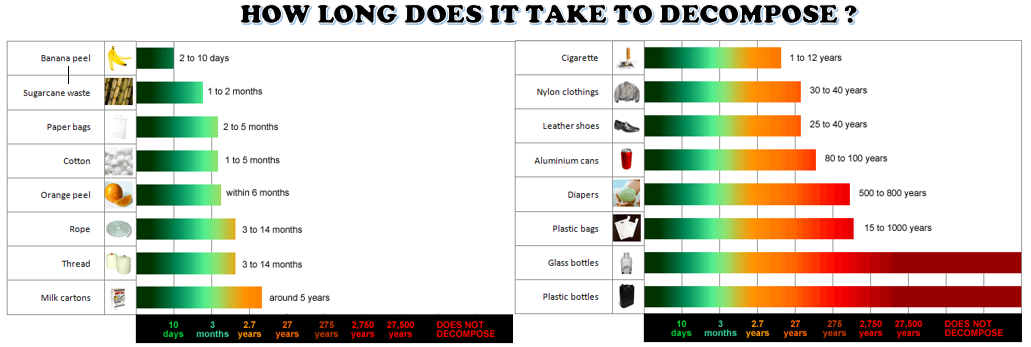

In [1]:
from IPython.display import Image
Image('./graph/GarbageDecomposition.png', width=1000, height=200)

Seeing the time that rubbish take to be destroyed, we must act quickly because the planet is polluted. We are going to give some examples of the impact of waste on the planet :
 - species extinction, for instance whales or turtles eat plastic bags
 - water pollution, groundwater and rivers contamination
 - soil pollution, lands are less ans less workable lands
 - organic waste cause greenhouse gas emissions (methane, carbon dioxide, ...)
 
Collect garbages becomes essential, we have to avoid mass consumerism and recover waste that can be. 

## <a style="color:#920037"> 1.2 Business model </a>

Imagine for a moment that environmental policies as discussed above have been set up and that one of the direct consequences of this would be a smartphone application accessible to all. From this application, the user can on a daily basis take pictures of situations in which there might be an illicit rubbish dump. Then, all of these pictures are collected and sent to a data team who is in charge to analyze them. 

The idea is to be able from the data collected, whether or not there are rubbish in the photos, to precisely determine the location where they had been left thanks to a geolocation service when photographes. Besides, in the case of garbages, we want to determine their type because depending on the location or quantity of waste, we will not use the same recovery service. Indeed, in order to protect the location where they had been left, it is necessary to adapt the means used to collect them. 

However, there are several constraints that must be respected :
1. to adapt the means used for collecting and then create value from garbages. On the one hand, It may seem naive, but it is not a good idea to send a large vehicle to recover a small amount of waste. On the other hand, it is necessary to take into account the place where these wastes are located with the aim of not deteriorating the environment.


2. to minimize the costs of the waste collection. For instance, in France, the waste collection is performed by the municipality so the financial means at their disposal to perform this task are partly dependent on the taxes paid by the taxpayer.


3. to determine which type the garbages belong to. Indeed, for instance, medical garbages need appropriate ways to be collected and they can not be collected with daily waste.

## <a style="color:#920037"> 1.3 The way to perform our model </a>

Waste can be classified in several ways but the following list represents the way we classify in our dataset :
1. city garbages

2. medical garbages

3. domestic waste

4. forest waste

5. non garbage


Indeed, users of the application can potentially upload a picture of an area where there is no waste. Hence, in order to avoid this kind of situations, we added a class « non garbage ». Furthermore, we have decided to classify rubbish into four categories. Indeed, on the one hand, it is important to separate medical garbages from the others since they require special attention because of the risks that may occur. On the other hand, we classify other garbages in « domestic garbage » for waste that don't require a large recovery service, in « city garbage » and « forest garbage » to pay attention to the environnement.

Data was mainly collected from internet and here we cite the refrences : 
- https://github.com/spotgarbage/spotgarbage-GINI
- https://www.pexels.com/
- https://pixabay.com/


Below, an example of differents pictures that we can find in our dataset :

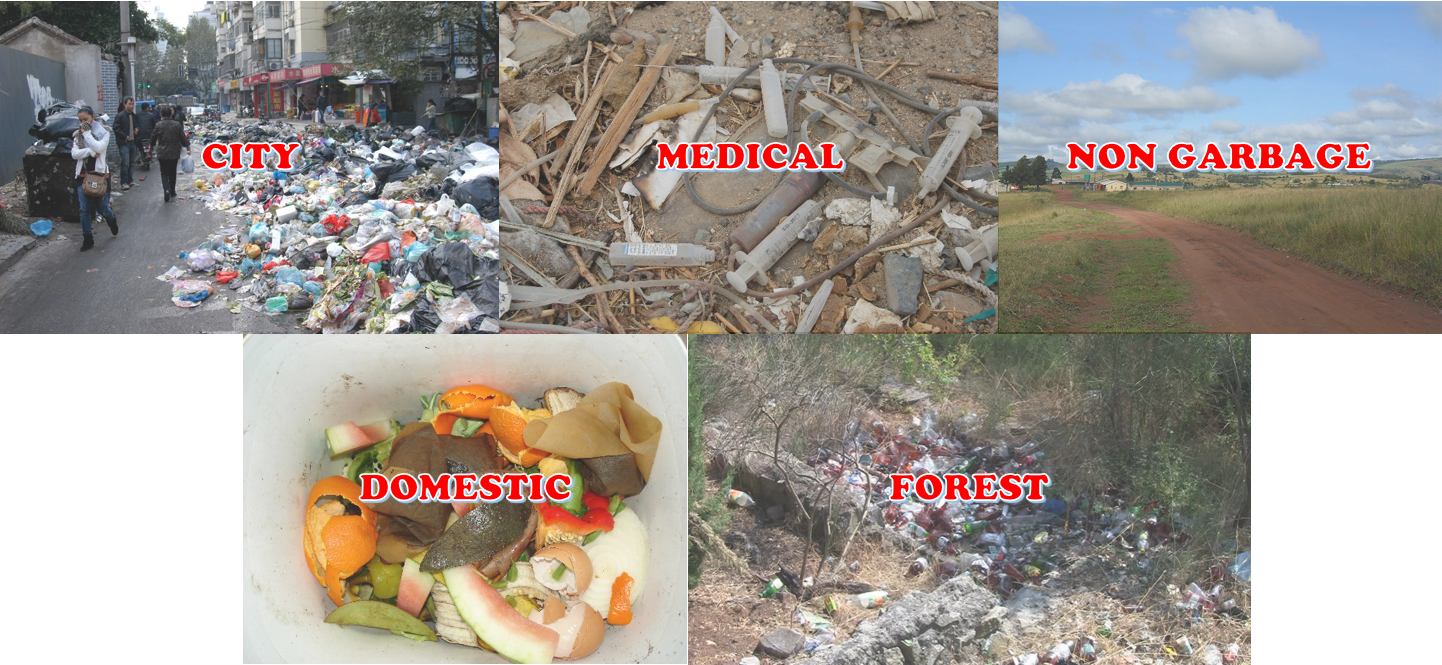

In [2]:
Image('./graph/Classes.png', width=1000, height=300)

# <a style="color:#920037"> 2. INSTALLATION OF LIBRAIRIES </a>

To get this starting kit running, the following dependencies are required : 

- numpy
- matplotlib
- pandas
- keras
- scikit-learn
- jupyter
- ramp-worflow
- os
- cv2
- download (used to upload data from dropbox url)

We recommend that you use the Python distribution from Anaconda and so to install those using conda.

In order to test submissions, the ramp-workflow package is needed. The lastest version from Github can be installed with pip : 

In [3]:
# !pip install git+https://github.com/paris-saclay-cds/ramp-workflow

In [4]:
pwd

'C:\\Users\\Alann\\Downloads\\Trash-classification-WJCAM'

# <a style="color:#920037"> 3. EXPLORATORY DATA ANALYSIS </a>

In [5]:
!python3 download_data.py

'python3' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [6]:
path_to_data = './data/'

In [7]:
import pandas as pd
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt

Loading our data

In [8]:
def loading_data(path, f_name):
    
    X_data=[]
    y_data=[]
    data_path = os.path.join(path, '{}.csv'.format(f_name))
    data = pd.read_csv(data_path)
    
    X_id = data['id_image'].values
    Y = data['label_image'].values
    
    for file in X_id:
        img = cv2.imread(os.path.join(path, "images", str(file)))
        X_data.append(np.asarray(img))                    
    
    return (np.array(X_data),np.array(Y))

In [9]:
X_data, y_data = loading_data(path_to_data, 'train')

Verify the shape of the date to ensure that it is loaded

In [10]:
X_data.shape

(513,)

## <a style="color:#920037"> 3.2 Data Description  </a>

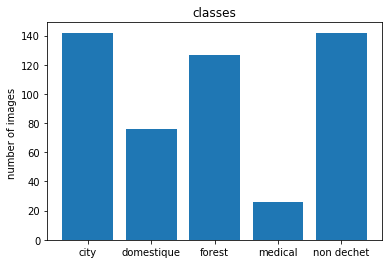

In [11]:
distributions = {}
for new_data_point in y_data :
    
    if new_data_point in distributions:
        distributions[new_data_point] += 1
    else:
        distributions[new_data_point] = 1
    

plt.bar(distributions.keys(), distributions.values());

plt.ylabel('number of images ')
plt.title('classes')
 
plt.show()

We notice that the 3 classes "city", "forest" and "non dechet" have more data than the classes "medical waste" and "domestique". So we should consider the fact the dataset is unbalanced in our models.

We show here some images (one image for each classes)

TypeError: Image data cannot be converted to float

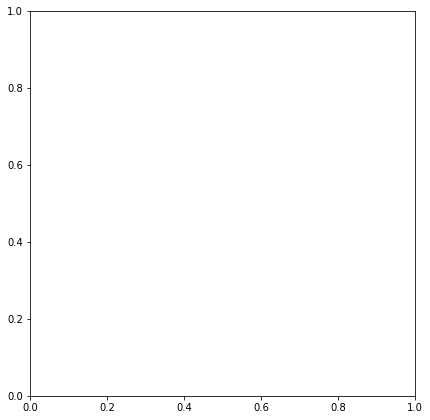

In [12]:
plt.figure(figsize=(40, 40))
L=[3,144,282,351,500]
titles=list(np.unique(y_data))
for i in range(5):
    ax=plt.subplot(1,5,i+1)
    plt.imshow(X_data[L[i]])
    plt.title(titles[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show

For example, we notice that even the photo of "non dechet" class is taken in a forest, so the model must be able to detect the place where the photo is taken, if there is trash or not and sometimes the type of the trash (like the case of medical waste class)

Read the csv file.
The csv file containes the id and the labels of each image

In [ ]:
pd.read_csv("data/train.csv").head()

## <a style="color:#920037"> 3.3 Data preprocessing  </a>

The labels of classes are strings, so we change our labels to numerical labels using dicto_generator function.

In [ ]:
def dictio_generator(s):
    d = dict()
    id_dictionnaire = 0
    d[s[0]] = id_dictionnaire
     
    for c in s : 
        if c not in d : 
            id_dictionnaire+= 1
            d[c] = id_dictionnaire
    return d

In [ ]:
# transforming  categorical Labels into numeric ones 
dicta = dictio_generator(np.unique(y_data))
y_data_numeric = np.array([ dicta[i] for i in y_data ])

We split the data on train and test sets to test our model manually. However, we will not need this split to run the model on the ramp

In [ ]:
from sklearn.model_selection import train_test_split
import keras

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_numeric, test_size=0.33, random_state=42)
print ('x_train size: ' , X_train.shape)
print ('x_test size:  ' , X_test.shape)
print ('y_train size: ' , y_train.shape)
print ('y_test size:  ' , y_test.shape)

We have 6 classes. Thus, we need to use One hot encoding method to have a better representation of our targets 

In [ ]:
# normalizing data
X_train = X_train.astype('float32') / 255.
X_test  = X_test.astype('float32') / 255.
one_hot_encoded_y_train = keras.utils.to_categorical(y_train,len(dicta))
one_hot_encoded_y_test = keras.utils.to_categorical(y_test,len(dicta))

# <a style="color:#920037"> 4. BASELINE MODEL  </a>

## <a style="color:#920037"> 4.1 Deep learning model  </a>

When managing images, data with high level complexity, we thought of Deep Neural networks as models capable of extracting features in an automatic way.

for that, using keras package we developed  a convolutional neural net with two hidden layer and a fully connected part that outputs a vector with dimension (num_classes,1)


Model is as such: 

   ![Alt text](https://jhui.github.io/assets/cnn/convolution_b1.png)
   
Where each layer is extracting more relative features from previous representation of data

First, we upload the necessary packages which are more likely to be used to develop the neural net

In [13]:
from __future__ import print_function
import numpy as np

import keras
from keras.datasets import mnist

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D 
from keras.optimizers import Adam, SGD, RMSprop

from keras.utils import np_utils 
from keras.callbacks import TensorBoard 
from keras import regularizers 
from time import time 

import matplotlib.pyplot as plt

Using TensorFlow backend.


Then we fix the hyper-parameters 

In [14]:
np.random.seed(1671) # for reproducibility
# network and training

NB_EPOCH = 10 # number of epochs/episodes 
BATCH_SIZE = 32
VERBOSE = 1
OPTIMIZER = SGD() # optimizer, explained later in this chapter
N_HIDDEN = 128

VALIDATION_SPLIT=0.1 # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.3
num_classes = 5 # number of outputs = number of digits

We have implementing a simple neural network define by:

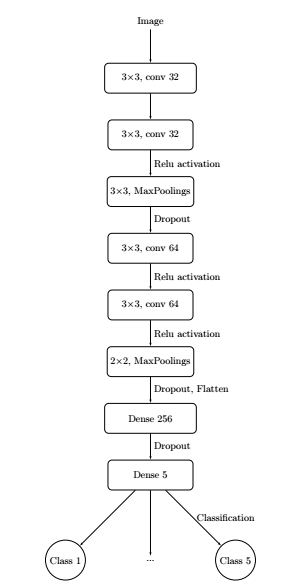

In [15]:
Image('./graph/architecture.PNG', width=400, height=150)

Model is defined as such 

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation=None, input_shape=(128,128,3)))
model.add(Conv2D(32,  (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(DROPOUT))

model.add( Conv2D (64,(3,3), activation = 'relu'))
model.add( Conv2D (64,(3,3), activation = 'relu'))
model.add( MaxPooling2D ( pool_size =(2,2)))
model.add(Dropout(DROPOUT))
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
          
        
sgd = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        
# training and fitting the model 

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_CNN', histogram_freq=0, 
                            batch_size=32, 
                            write_graph=True, 
                            write_grads=True, write_images=True,
                            embeddings_freq=0, embeddings_layer_names=None,
                            embeddings_metadata=None)

""" tensorboard --logdir ./logs_CNN"""

Before doing any training, we need to resize the images in the goal that they matches the input shape of the model.

In [ ]:
X_train_resize = np.zeros(( len(X_train), 128, 128, 3))
for i in range(len(X_train)):
    X_train_resize[i] = cv2.resize(X_train[i], (128, 128))
    
X_test_resize = np.zeros(( len(X_test), 128, 128, 3))
for i in range(len(X_test)):
    X_test_resize[i] = cv2.resize(X_test[i], (128, 128))

We train our neural network for a fixed number of epochs and with the respect to the other hyper-parameters 

In [ ]:
history = model.fit(X_train_resize, one_hot_encoded_y_train, batch_size=BATCH_SIZE,
                   epochs=NB_EPOCH,validation_split = VALIDATION_SPLIT,
          callbacks=[tensorboard])


We can then move on analysing the performance of the model 

In [ ]:
# Metrics evaluation 
#tensorboard --logdir=logs/
score = model.evaluate(X_test_resize, one_hot_encoded_y_test, verbose=VERBOSE,batch_size=BATCH_SIZE)
print("Test score:", score[0])
print('Test accuracy:', score[1])


Besides, an important point to verify is to check if we are learning something and not overfitting and learning too much about our train data 

In [ ]:
# tensorboard logs 
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Hint : if the gap between the train plot and the validation one is too large, then we are facing an overfitting problem 
we might want to adjust our hyper-parameters, or manage our data set size...

## <a style="color:#920037"> 4.2 Second variant of CNN : CNN + Data augmentation  </a>

Having a relatively small data set, one way to adress the overfitting problem is to use the data augmentation method,
meaning apply basic modifications on input images such as ( flip, zoom, random noise, rotation...).

We then conserve the information within our input data and enlarge our data set, which has strong impact on our metrics results and the model performance.

One might use the keras ImageDataGeneraor and choose the type of modifications to apply

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In chase of computation limitations, we might generate data while performing the training of the network, in a way to not lose much time and space to create new data points(images) and save them in independant folders which might take huge space

We maintain the same structure of the model, but this time we fit our model with data generated from data augmentation process, hyper-parameters could be adjusted also as needed 

In [ ]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_resize)

# fits the model on batches with real-time data augmentation:
history_augmented = model.fit_generator(datagen.flow(X_train_resize, one_hot_encoded_y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train_resize) / 32, epochs=NB_EPOCH,validation_steps=2)

After that we porceed to evaluate our model efficiency, when evaluating the model, we should maintain the same transformations applied to our train data as well for our test data 

In [ ]:
test_datagen= datagen.flow(X_test_resize, one_hot_encoded_y_test, batch_size=BATCH_SIZE)

In [ ]:
scoreSeg = model.evaluate_generator(test_datagen, 100)
print("loss_function",scoreSeg[0], "Accuracy = ",scoreSeg[1])

# <a style="color:#920037"> 5. SUBMISSION ON RAMP </a>

## <a style="color:#920037"> 5.1 Submission files  </a>

After you find a good model, you have to write an ImageClassifier class on the goal to do a submission.<br/>
Here, is a example of ImageClassifier class implementing the model explain above.


In [ ]:
# %load ./submissions/starting_kit/image_classifier.py
import numpy as np


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import cv2

class ImageClassifier(object):

    def __init__(self, batch_size=32, epochs=1, validation_split=0.2, dropout=0.3, input_shape_image=(128, 128)):
        
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.step_per_epoch = 20
        self.input_image_shape = input_shape_image
        self.input_shape = self.input_image_shape + (3,)
        self.dropout = dropout
        self.validation_split = validation_split
        self.model = self._build_model()

    def _transform(self, x):   
        x = x / 255.
        x_resize = cv2.resize(x, self.input_image_shape)
        return x_resize
    
    def data_augmentation(self, X):
        datagen = ImageDataGenerator(
                featurewise_center=True,
                featurewise_std_normalization=True,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True)
        # compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied)
        
        datagen.fit(X)
        return datagen

    def fit(self, img_loader):
        nb = len(img_loader)
        X = np.zeros((nb,) + self.input_shape)
        Y = np.zeros((nb, 5))
        
        for i in range(nb):
            x, y = img_loader.load(i)
            X[i] = self._transform(x)
            Y[i, y] = 1
            
        datagen = self.data_augmentation(X)
        
        self.model.fit_generator(datagen.flow(X, Y, batch_size=self.batch_size), steps_per_epoch=self.step_per_epoch, epochs=self.epochs)
     
    def predict_proba(self, img_loader):
        nb = len(img_loader)
        X = np.zeros((nb, 128, 128, 3))
        for i in range(nb):
            X[i] = self._transform(img_loader.load(i))
        return self.model.predict(X)
    
    def _build_model(self):
        
        model = Sequential()


        model.add(Conv2D(32, (3,3), activation=None, input_shape=self.input_shape))
        model.add(Conv2D(32,  (3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(self.dropout))

        model.add( Conv2D (64,(3,3), activation = 'relu'))
        model.add( Conv2D (64,(3,3), activation = 'relu'))
        model.add( MaxPooling2D ( pool_size =(2,2)))
        model.add(Dropout(self.dropout))
        model.add(Flatten())
        model.add(Dense(256,activation = 'relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
          
        
        sgd = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        
        return model


## <a style="color:#920037"> 5.2 Local testing before submitted to RAMP  </a>

You have to test your submissions files before doing your submissions. In that goal, use ramp_test_submission command. Notice that this unit test run in the folder [`submissions/starting_kit`](/tree/submissions/starting_kit).
Before running the test, make sure you have done the following tasks:

- install ramp-workflow
- write the python file image_classifier.py and put it in the following folder [`submissions/starting_kit`].
- download the data by excuting `python download_data.py`

You have two possibility to test your submissions, a complete test (train and test the model with cross validtion like the server or a quick test (just to make sure the submissions code are working). If the test run, print train and test erros on each fold of the cross validation you can then submit to ramp.

Execute the following cell to do a quick test:

In [ ]:
!ramp_test_submission --quick-test

And the following cell to do a complete test

In [ ]:
!ramp_test_submission